# Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
world = pd.read_csv('https://raw.githubusercontent.com/anyaiyer/covid-19-analysis/main/worldometer_data.csv')

In [3]:
full = pd.read_csv('https://raw.githubusercontent.com/anyaiyer/covid-19-analysis/main/full_grouped.csv')
# used in Prophet model

In [4]:
covid = pd.read_csv('https://raw.githubusercontent.com/anyaiyer/covid-19-analysis/main/country_wise_latest.csv')

In [5]:
day = pd.read_csv('https://raw.githubusercontent.com/anyaiyer/covid-19-analysis/main/day_wise.csv')

# Data PreProcessing

In [6]:
covid.isnull().sum() # no null values

Country/Region            0
Confirmed                 0
Deaths                    0
Recovered                 0
Active                    0
New cases                 0
New deaths                0
New recovered             0
Deaths / 100 Cases        0
Recovered / 100 Cases     0
Deaths / 100 Recovered    0
Confirmed last week       0
1 week change             0
1 week % increase         0
WHO Region                0
dtype: int64

In [7]:
day.isnull().sum() # no null values

Date                      0
Confirmed                 0
Deaths                    0
Recovered                 0
Active                    0
New cases                 0
New deaths                0
New recovered             0
Deaths / 100 Cases        0
Recovered / 100 Cases     0
Deaths / 100 Recovered    0
No. of countries          0
dtype: int64

In [8]:
day['Date']=pd.to_datetime(day['Date']) # converting Data into datetime

In [9]:
day['Day'] = day['Date'].apply(lambda x: x.hour)
day['Month'] = day['Date'].apply(lambda x: x.month)
day['Year'] = day['Date'].apply(lambda x: x.dayofweek)

This creates seperate numerical columns with the year, month, and day.

In [10]:
day_temp = day.copy()
day_temp = day_temp.drop('Date',axis=1)
day_temp.head()

,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries,Day,Month,Year
0,555,17,28,510,0,0,0,3.06,5.05,60.71,6,0,1,2
1,654,18,30,606,99,1,2,2.75,4.59,60.00,8,0,1,3
2,941,26,36,879,287,8,6,2.76,3.83,72.22,9,0,1,4
3,1434,42,39,1353,493,16,3,2.93,2.72,107.69,11,0,1,5
4,2118,56,52,2010,684,14,13,2.64,2.46,107.69,13,0,1,6


day_temp will be used in model

# Model for Confirmed Cases

## Train Test Split

In [11]:
from sklearn.model_selection import train_test_split

X = day_temp.drop('Confirmed',axis=1).values
y = day_temp['Confirmed'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Building Neural Network Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
X_train.shape

(131, 13)

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

MinMaxScaler scales each feature to a given range. This is known as feature scaling and normalizes the range of features in the data. This allows the neural network to converge faster to the local minimum. 

To learn more about why feature scaling is important, [read this article](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35).

In [14]:
model = Sequential()

model.add(Dense(19,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(19,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(19,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(19,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

When building the model, it is important to use [dropout layers](https://keras.io/api/layers/regularization_layers/dropout/) to prevent overfitting. The activation function is [relu](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/#:~:text=The%20rectified%20linear%20activation%20function,otherwise%2C%20it%20will%20output%20zero.&text=The%20rectified%20linear%20activation%20function%20overcomes%20the%20vanishing%20gradient%20problem,learn%20faster%20and%20perform%20better.) (rectified linear unit) with the optimizer being [adam](https://www.tensorflow.org/swift/api_docs/Classes/Adam). Relu is a piecewise linear function that is easy to train and is generally the default activation function. The adam optimizer helps update weights more efficiently than stochastic gradient descent (adam is an extension of this).

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
#early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)
model.fit(x=X_train,y=y_train,epochs=600,validation_data=(X_test,y_test),callbacks=[],verbose=0)
# verbose is at 0 because of the many epochs

[EarlyStopping](https://en.wikipedia.org/wiki/Early_stopping) is another way to prevent overfitting, but I found that this model did better without it. 

In [18]:
sns.set_style('darkgrid')

<AxesSubplot:>

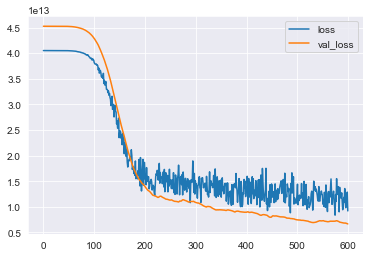

In [19]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [47]:
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_percentage_error

In [21]:
predictions = model.predict(X_test)
np.sqrt(mean_squared_error(y_test,predictions))

2580990.1900642896

In [22]:
from sklearn.metrics import mean_absolute_error

In [23]:
mean_absolute_error(y_test,predictions)

1830224.2061403508

In [24]:
explained_variance_score(y_test,predictions)

0.7448295582887807

In [48]:
mean_absolute_percentage_error(y_test, predictions) # 10% - 20% is a good range for MAPE

14.927865502456863

Since MAE and MSE are scale dependent, this might be why they are so high, and why explained variance score and MAPE are not bad. This could be because the dataset is very small with only 189 entries. 

## Prophet Model

Let's try another way to predict COVID-19 cases using Prophet.

[Prophet](https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/) is a forecasting tool from Facebook that uses the data to predict future behavior. It is an additive regression model, a nonparametric model, ( these are contructed using info from the data rather than taking a predetermined form). One benefit is that additive regression models are more flexible than regular linear regression models. 

Through this model, Prophet has 4 main components:
- list of holidays (from user)
- weekly seasonal component with dummy variables
- yearly seasonal component with Fourier series
- piecewise linear/logistic curve trend (selects points in the data to detect changes in trends) 

To learn the basics of Prophet, click [here](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

In [25]:
from fbprophet import Prophet

In [26]:
conf_data = full[['Date', 'Confirmed']].groupby('Date', as_index = False).sum()
conf_data.columns = ['ds', 'y']
conf_data.ds = pd.to_datetime(conf_data.ds)

In [27]:
conf_data.head()

,ds,y
0,2020-01-22,555
1,2020-01-23,654
2,2020-01-24,941
3,2020-01-25,1434
4,2020-01-26,2118


In [28]:
proph = Prophet()
proph.fit(conf_data)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
confirmed_pred = proph.make_future_dataframe(periods=60)
confirmed_pred.tail()

,ds
243,2020-09-21
244,2020-09-22
245,2020-09-23
246,2020-09-24
247,2020-09-25


In [30]:
confirmed_forecast = proph.predict(confirmed_pred)
confirmed_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
243,2020-09-21,2.756564e+07,2.636139e+07,2.880034e+07
244,2020-09-22,2.775515e+07,2.654391e+07,2.901219e+07
245,2020-09-23,2.796512e+07,2.673004e+07,2.931087e+07
246,2020-09-24,2.817921e+07,2.692347e+07,2.949993e+07
247,2020-09-25,2.839455e+07,2.709071e+07,2.978914e+07


yhat is the forecast, and yhat_lower & yhat_upper are the uncertainty interval.

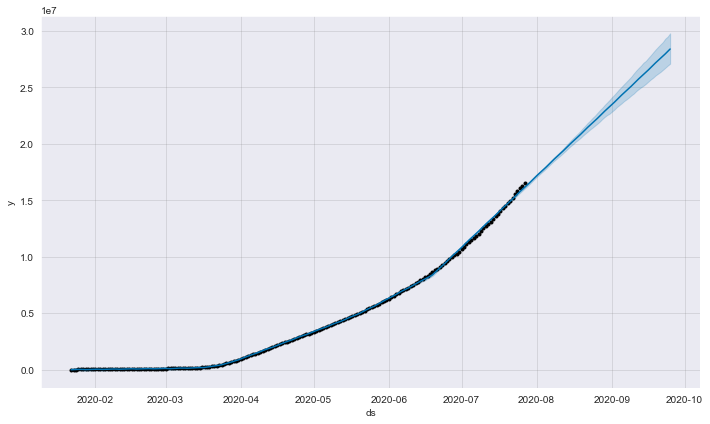

In [31]:
fig1 = proph.plot(confirmed_forecast)

The black dots represent the true y values while the blue line represents the forecast or predicted trend. From this graph, we can see that the Prophet model is doing a good job at predicting the number of confirmed cases as the data matches up with the predictions. 

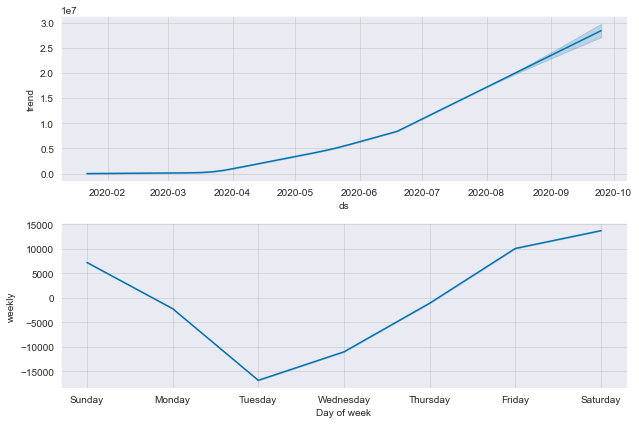

In [32]:
fig2 = proph.plot_components(confirmed_forecast)

This shows the yearly and weekly seasonilty of the cases trend. There is a steady increase in cases from February 2020 to October 2020. The weekly graph shows that Saturday tends to have the most cases with Tuesday having the least amount of cases.

# Model for Deaths

In [33]:
deaths_data = full[['Date', 'Deaths']].groupby('Date', as_index = False).sum()
deaths_data.columns = ['ds', 'y']
deaths_data.ds = pd.to_datetime(deaths_data.ds)

In [34]:
deaths_data.head()

,ds,y
0,2020-01-22,17
1,2020-01-23,18
2,2020-01-24,26
3,2020-01-25,42
4,2020-01-26,56


In [35]:
proph2 = Prophet()
proph2.fit(deaths_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
deaths_pred = proph2.make_future_dataframe(periods=60)
deaths_pred.tail()

,ds
243,2020-09-21
244,2020-09-22
245,2020-09-23
246,2020-09-24
247,2020-09-25


In [37]:
deaths_forecast = proph2.predict(deaths_pred)
deaths_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
243,2020-09-21,928776.925088,867210.424739,9.926054e+05
244,2020-09-22,933982.798883,870206.925008,1.000483e+06
245,2020-09-23,939549.453660,876034.632739,1.007656e+06
246,2020-09-24,945159.444018,877303.400192,1.015817e+06
247,2020-09-25,950675.516617,882386.344743,1.022260e+06


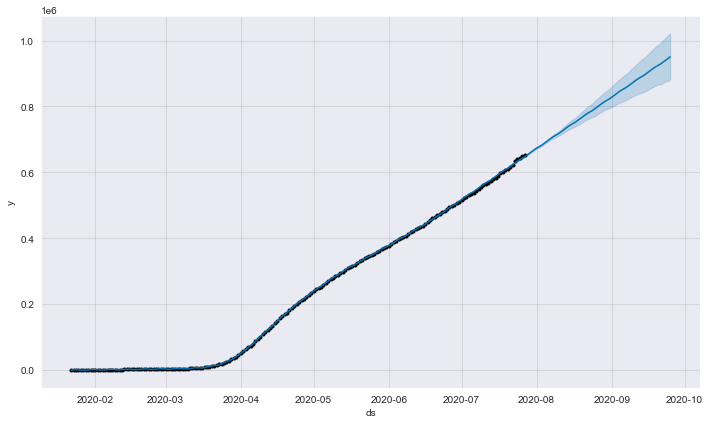

In [38]:
fig3 = proph2.plot(deaths_forecast)

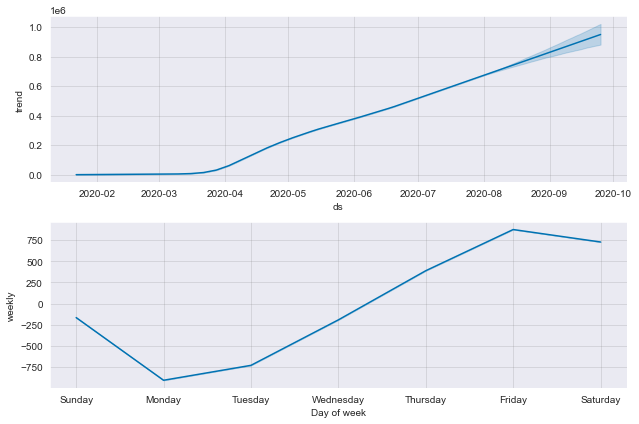

In [39]:
fig4 = proph2.plot_components(deaths_forecast)

The deaths were flattening at the beginning of 2020, but as time went on, the death cases began increasing. The most amount of deaths or on Saturday and the least amount of deaths is on Monday.

# Model for Recovered

In [40]:
rec_data = full[['Date', 'Recovered']].groupby('Date', as_index = False).sum()
rec_data.columns = ['ds', 'y']
rec_data.ds = pd.to_datetime(rec_data.ds)

In [41]:
rec_data.head()

,ds,y
0,2020-01-22,28
1,2020-01-23,30
2,2020-01-24,36
3,2020-01-25,39
4,2020-01-26,52


In [42]:
proph3 = Prophet()
proph3.fit(rec_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
rec_pred = proph3.make_future_dataframe(periods=60)

In [44]:
rec_forecast = proph3.predict(deaths_pred)
rec_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
243,2020-09-21,1.684121e+07,1.606682e+07,1.763614e+07
244,2020-09-22,1.696856e+07,1.615125e+07,1.778301e+07
245,2020-09-23,1.711079e+07,1.629129e+07,1.791754e+07
246,2020-09-24,1.725357e+07,1.636882e+07,1.812905e+07
247,2020-09-25,1.739511e+07,1.653804e+07,1.827193e+07


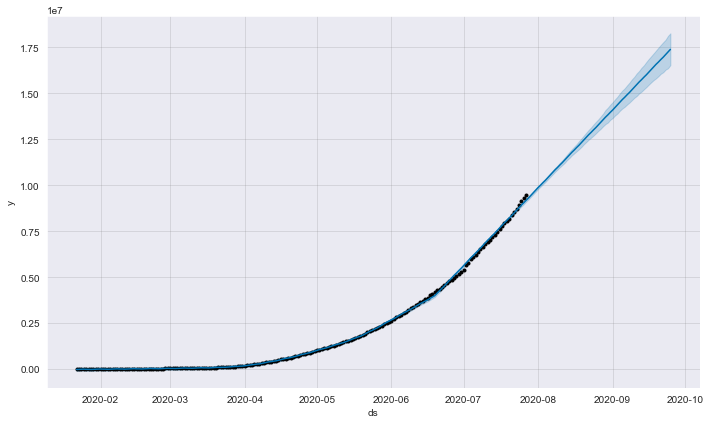

In [45]:
fig5 = proph3.plot(rec_forecast)

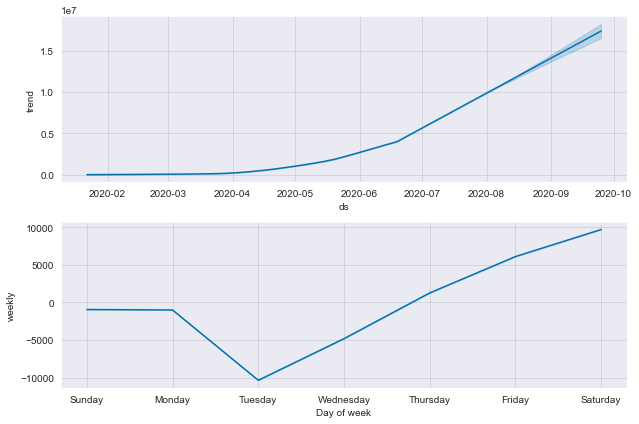

In [46]:
fig6 = proph3.plot_components(rec_forecast)

There is an increase in recovered cases. Saturday tends to have the most recovered cases while Tuesday has the least amount of recovered cases. 